In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools

from stripROtools import colors



In [57]:
T_off = pd.read_pickle("time_offset.pk")
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC a,-5.208232,0.034228,16.305925,0.026783
2,UH DLC a,6.752723,0.038583,14.113659,0.031446
3,UH DLC a,6.852294,0.058807,14.800689,0.048234
4,UH DLC a,5.703480,0.075588,19.574833,0.061573
5,UH DLC a,5.473110,0.114114,19.799337,0.092169
6,UH DLC a,25.241775,0.189180,18.082547,0.159142
7,UH DLC a,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Explore UH DLC Micromegas - Quadrant a

In [58]:
Vmesh = [540]

selecting tracks fiducial on quadrant a...
----- Hits on y strips -----


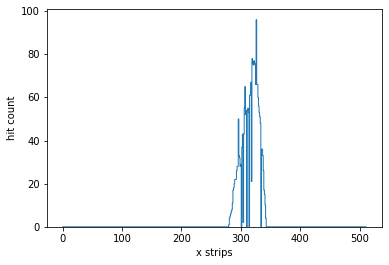

----- Hits on y strips -----


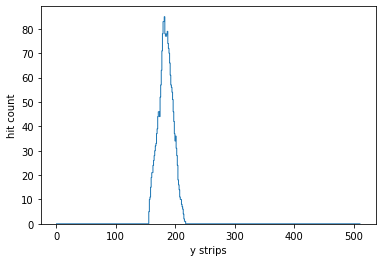

----- Event Time Range-----


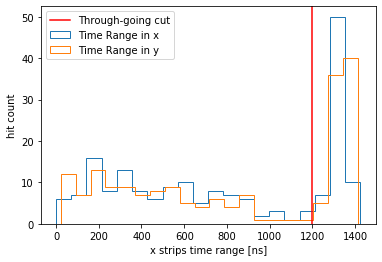

----- ADC distribution-----


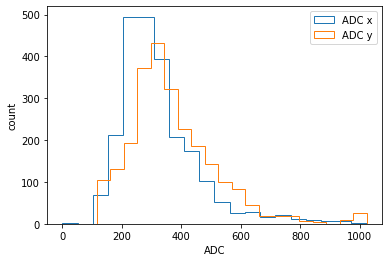

selecting through-going tracks within 25 degrees of vertical...
Number of remaining events:  31
----- hits in x and y  -----


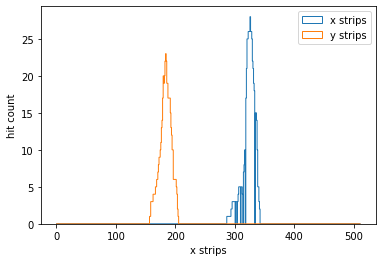

In [59]:
for V in Vmesh:

    # Location of data
    if V == 540:
        # Vmesh = 540 has multiple files
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_2_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root", "/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/540Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]
    else:
        file_loc = ["/Users/majdghrear/data/VMM3a_SRS/AUG23/UH_DLC/Po210/"+str(V)+"Vmesh_bc_40p000_tac_60_ccs_6_cs_3_dt_200_mst_15_spc_1700_dp_400_cr_0p00-1000p00_coin_center-of-mass_test.root"]

    # Create pandas data frame of the cluster info
    df_cluster = stripROtools.read_root(file_loc, clusters=True, hits=False)

    # Define additional columns

    # number of hits
    df_cluster["nhits"]=df_cluster.apply(lambda row: len(row.strips0)+len(row.strips1) ,axis=1)
    df_cluster["electrons_x"] = df_cluster.adc0.apply(lambda x: 6240 * ( x  / 9.0 ) ) # 9 mV/fC is VMM gain setting for x channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons_y"] = df_cluster.adc1.apply(lambda x: 6240 * ( x / 4.5 ) ) # 4.5 mV/fC is VMM gain setting for y channels, 170mV is the pedestal, 1200mV is th operating voltage 1024 is the number of possible ADC values
    df_cluster["electrons"] = df_cluster.electrons_x + df_cluster.electrons_y

    # length on x/y plane in units of strip lengths
    df_cluster["L"]=np.sqrt((df_cluster.strips0.apply(np.max) - df_cluster.strips0.apply(np.min))**2 + (df_cluster.strips1.apply(np.max) - df_cluster.strips1.apply(np.min))**2)

    # time range on x strips
    df_cluster["TR0"] = df_cluster.times0.apply(np.max)-df_cluster.times0.apply(np.min)

    # time range on y strips
    df_cluster["TR1"] = df_cluster.times1.apply(np.max)-df_cluster.times1.apply(np.min)

    print("selecting tracks fiducial on quadrant a...")
    
    #fiducialize clusters on s ingle vmmm combo in xHyL
    df_cluster = stripROtools.fiducializeVMM(df_cluster, n_vmm_x=5, n_vmm_y=10, min_hits=5, map="UH")

    # plot the x hits
    strip_edges = np.arange(-0.5,512.5,1.0)


    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips0),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()
    # plot the y hits

    print("----- Hits on y strips -----")
    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cluster.strips1),bins=strip_edges,histtype='step')
    bin_centers = (bins+(bins+1))/2
    #plt.axvline(bin_centers[np.argmax(n)],color='k',label=str(int(bin_centers[np.argmax(n)])) )
    plt.xlabel("y strips")
    plt.ylabel("hit count")
    plt.show()

    # Plot the time range in x, throughgoing alphas take up the largets time range
    print("----- Event Time Range-----")

    plt.figure()
    plt.hist(df_cluster["TR0"],bins=20,histtype='step', label="Time Range in x")
    plt.hist(df_cluster["TR1"],bins=20,histtype='step', label="Time Range in y")
    plt.axvline(1200, color='r',label="Through-going cut")
    plt.xlabel("x strips time range [ns]")
    plt.ylabel("hit count")
    plt.legend()
    plt.show()


    #Plot ADC x distribution
    print("----- ADC distribution-----")

    plt.figure()
    plt.hist(np.concatenate(df_cluster.adcs0), bins=20, histtype="step", label="ADC x")
    plt.hist(np.concatenate(df_cluster.adcs1), bins=20, histtype="step", label="ADC y")
    plt.xlabel("ADC")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    print("selecting through-going tracks within 25 degrees of vertical...")

    # Cut for throughgoing events  with over 8 hits that are within 25 degrees of vertical
    df_cut = df_cluster.loc[ (df_cluster.TR0 > 1200) & (df_cluster.TR1 > 1200) & (df_cluster.nhits > 8) & (df_cluster.L <= 28) ]
    df_cut=df_cut.reset_index(drop=True)

    print("Number of remaining events: ", len(df_cut) )

    print("----- hits in x and y  -----")

    # Plot x hits

    plt.figure()
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips0),bins=strip_edges,histtype='step',label= "x strips")
    n,bins,patches = plt.hist(np.concatenate(df_cut.strips1),bins=strip_edges,histtype='step',label= "y strips")
    plt.legend()
    plt.xlabel("x strips")
    plt.ylabel("hit count")
    plt.show()




In [45]:
# A function to get the transverse mismeasurments of a 3D reconstrcuted alpha track
def GetTransErrs(x_vals,y_vals,z_vals,charges):

    X = np.array([x_vals,y_vals,z_vals]).T

    # 1) Center on barycenter
    # Barycenter is the charge-weighted mean position
    x_b = np.sum(X*(charges.reshape(len(charges),1)),axis=0)/np.sum(charges)
    # Shift data to barycenter
    X = X-x_b

    # 2) Find principle axis
    # Use charges for weights
    W = charges.reshape(len(charges),1)
    # Compute weighted covariance matrix
    WCM = ( (W*X).T @ X ) / np.sum(W)
    U1,S1,D1 =  np.linalg.svd(WCM)
    v_PA = np.array([D1[0][0],D1[0][1],D1[0][2]])

    v_PA = np.sign(v_PA[2]) * v_PA

    # projection of mean-centered position onto principle axis
    proj = np.array([(X@v_PA)*v_PA[0],(X@v_PA)*v_PA[1],(X@v_PA)*v_PA[2]]).T

    # Mismeasurement vectors
    # The distribution of the x and y values gives us sigma x and sigma y
    err =X-proj

    # Compute transverse mismeasurements using method 1
    delta_xs_1 = err[:,0]
    delta_ys_1 = err[:,1]

    # Compute transverse mismeasurements using method 2
    delta_xs_2 = X[:,0] - ( ( v_PA[0] / v_PA[2] ) * X[:,2] ) 
    delta_ys_2 = X[:,1] - ( ( v_PA[1] / v_PA[2] ) * X[:,2] )
    
    return z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b


    

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:650: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


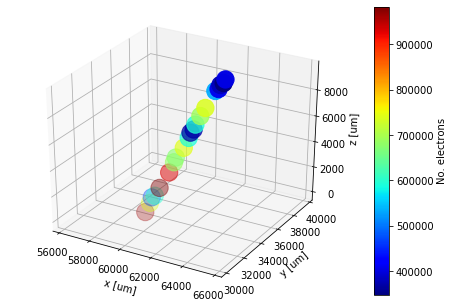

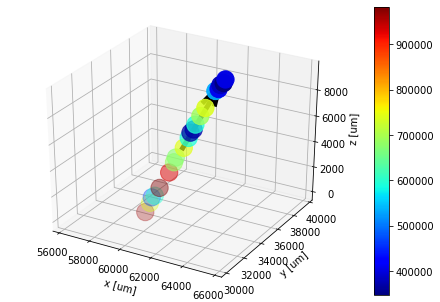

In [46]:
# Plot a track and Fit as a sanity check

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

test_event = df_cut.iloc[3]

# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, gain_x=9, gain_y=4.5, v_drift=8.0)

# Remove delayed hits (as discussed in the slides)
dsp.prune_track(T_L = 40, T_H=250)
dsp.prune_track2(gap=2)

x_vals,y_vals,z_vals,charges = dsp.Reconst3D_v1( mu = -6.68, sigma = 16.4 , n_sigma = 3)

z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, direction, start = GetTransErrs( x_vals,y_vals,z_vals,charges)
direction = 5000*direction

# Plot the 3D scatter
fig = plt.figure()
ax = Axes3D(fig)

#set color map
cm = plt.get_cmap('jet')
cNorm = matplotlib.colors.Normalize(vmin=min(charges), vmax=max(charges))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
                
ax.scatter(x_vals, y_vals, z_vals, c=scalarMap.to_rgba(charges),s=300)
ax.quiver(start[0],start[1],start[2],direction[0],direction[1],direction[2], linewidths=5, color = 'k')
scalarMap.set_array(charges)
fig.colorbar(scalarMap)

# Force all axis to have equal limits
extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
sz = extents[:,1] - extents[:,0]
centers = np.mean(extents, axis=1)
maxsize = max(abs(sz))
r = maxsize/2
for ctr, dim in zip(centers, 'xyz'):
    getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# Set labels
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_zlabel('z [um]')
                
plt.show()

# Perform point res analysis

In [47]:

all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

# Loop through tracks after all selection cuts
for indx in range(len(df_cut)):

    try:

        event = df_cut.iloc[indx]

        # Make a TrackTools object for the event
        dsp = stripROtools.TrackTools(event = event, gain_x=9, gain_y=4.5, v_drift=8.0)

        # Remove delayed hits (as discussed in the slides)
        dsp.prune_track(T_L = 40, T_H=250)
        dsp.prune_track2(gap=2)
        x,y,z,c = dsp.Reconst3D_v1( mu = -6.68, sigma = 16.4 , n_sigma = 3, plot = False)

        # Only consider tracks with 5 or more points
        if len(x) > 5:

            # Get error vectors
            z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c)

            all_z = np.append(all_z,z_vals)
            all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
            all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
            all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
            all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
            

        
    except:
        pass

In [48]:
# Switch to cm
all_z = all_z*1E-4

In [49]:
from scipy import stats
from scipy.optimize import curve_fit

# Gaussian Function
def gaus(x, y_off, const, mu, sigma):
    return y_off + const* np.exp(-0.5*((x - mu)/sigma)**2)

In [61]:

def Mismeasurment_vs_z( all_z, x_mis , y_mis , start = 0.1, stop = 1.0, step = 0.2, plot = True):

    abs_z = []
    x_sigmas = []
    x_sigmas_err = []
    y_sigmas = []
    y_sigmas_err = []

    for z_low in np.arange(start,stop,step):

        #make data cut
        z_high = z_low + step
        data_cut = (all_z > z_low) & (all_z < z_high)


        xmin = -150
        xmax = 150
        ymin = -150
        ymax = 150


        nbins = 8

        hist_x, bin_edges_x = np.histogram(x_mis[data_cut],nbins,(xmin,xmax))
        hist_y, bin_edges_y = np.histogram(y_mis[data_cut],nbins,(ymin,ymax))

        bin_centers_x = (bin_edges_x[1:]+bin_edges_x[:-1])/2.
        bin_centers_y = (bin_edges_y[1:]+bin_edges_y[:-1])/2.

        # Find non-zero bins in Histogram
        nz_x = hist_x>0
        nz_y = hist_y>0

        # Get posssion error bars for non-zero bins
        n_err_x = np.sqrt(hist_x[nz_x])
        n_err_y = np.sqrt(hist_y[nz_y])

        # Fit Gaussian to binned data
        coeff_x, covar_x = curve_fit(gaus, bin_centers_x[nz_x], hist_x[nz_x], sigma=n_err_x, absolute_sigma=True, p0=(0,100,0,50))
        coeff_y, covar_y = curve_fit(gaus, bin_centers_y[nz_y], hist_y[nz_y], sigma=n_err_y, absolute_sigma=True, p0=(0,100,0,50))

        # Compute fit (statistical) errors
        perr_x = np.sqrt(np.diag(covar_x))
        perr_y = np.sqrt(np.diag(covar_y))

        print("sigma x: ", coeff_x[3], "+/-", perr_x[3])
        print("sigma y: ", coeff_y[3], "+/-", perr_y[3])

        if plot == True:
            plt.figure()
            hist, bin_edges,patches = plt.hist(x_mis[data_cut],nbins,(xmin,xmax),color = colors["blue"], histtype="step", label = str( round( (z_low+z_high)/2.0 ,2) )+"abs. z, x")
            plt.errorbar(bin_centers_x[nz_x], hist_x[nz_x], n_err_x,color = colors["blue"])
            hist, bin_edges,patches = plt.hist(y_mis[data_cut],nbins,(ymin,ymax),color = colors["red"],histtype="step", label = str( round( (z_low+z_high)/2.0 ,2) )+"abs. z, y")
            plt.errorbar(bin_centers_y[nz_y], hist_y[nz_y], n_err_y,color = colors["red"])
            plt.xlabel("Transverse Mismeasurment [um]")
            plt.ylabel("Count")

            IV = np.arange(xmin,xmax,1)

            f_opti_x = gaus(IV,*coeff_x)
            f_opti_y = gaus(IV,*coeff_y)


            plt.plot(IV, f_opti_x,color = colors["blue"], linestyle='--', linewidth=2)
            plt.plot(IV, f_opti_y,color = colors["red"], linestyle='--', linewidth=2)
            plt.legend()
            plt.show()

        abs_z += [round( (z_low+z_high)/2.0 ,2)]
        x_sigmas += [coeff_x[3]]
        x_sigmas_err += [perr_x[3]]
        y_sigmas += [coeff_y[3]]
        y_sigmas_err += [perr_y[3]]

    return abs_z, x_sigmas, x_sigmas_err, y_sigmas, y_sigmas_err




sigma x:  42.6735870711344 +/- 11.528888154357881
sigma y:  53.09408268151176 +/- 26.494118489291328


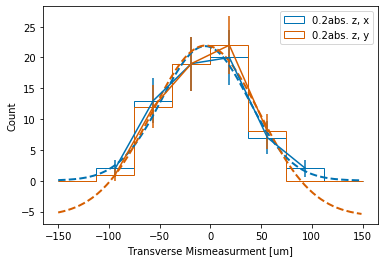

sigma x:  23.84405835446588 +/- 4.124498012598734
sigma y:  61.151453279533435 +/- 33.52395952782172


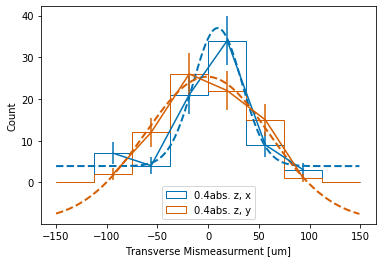

sigma x:  296.61728286227367 +/- 5227.043767587606
sigma y:  36.04586173665465 +/- 4.265431977555432


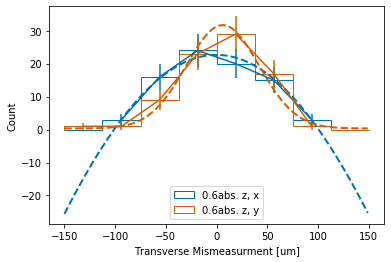

sigma x:  59.540721962403815 +/- 24.247777064614855
sigma y:  65.2209685597269 +/- 40.965106245120225


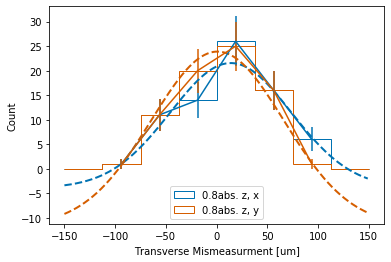

sigma x:  71.17883725271714 +/- 23.314717540780993
sigma y:  62.8394055742436 +/- 27.330807438582823


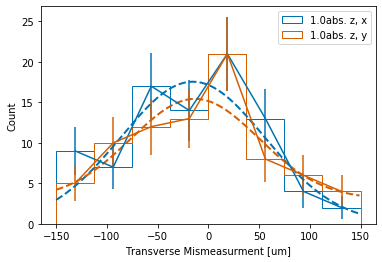

In [62]:
# Git mismeasurement versus abs. z using method 1

abs_z, x_sigmas1, x_sigmas_err1, y_sigmas1, y_sigmas_err1 = Mismeasurment_vs_z(all_z=all_z, x_mis=all_x_err_1 , y_mis = all_y_err_1) 


Text(0, 0.5, 'Effective Point Resolution [um]')

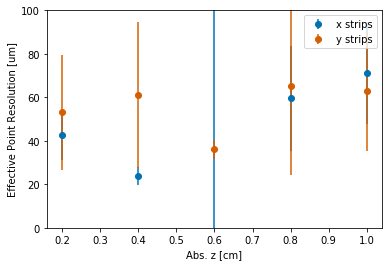

In [52]:
plt.errorbar(abs_z,x_sigmas1,x_sigmas_err1, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,y_sigmas1,y_sigmas_err1, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.legend()
plt.ylim((0,100))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")






sigma x:  40.43773666952121 +/- 6.39435976421125
sigma y:  46.28285045395891 +/- 16.378355429874453


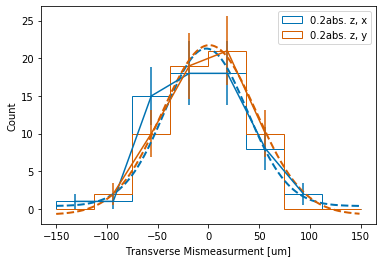

sigma x:  24.96317643554706 +/- 4.440188917854433
sigma y:  54.698543095591475 +/- 22.50571716996556


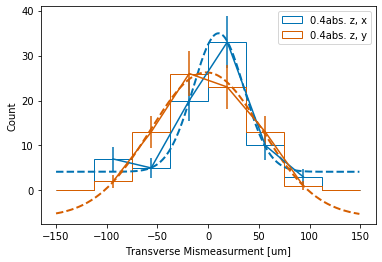

sigma x:  64.14221950617616 +/- 49.69690240846668
sigma y:  37.46450140892396 +/- 4.50007237828918


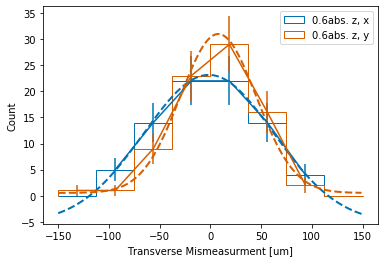

sigma x:  70.94392730430415 +/- 42.24471930071331
sigma y:  49.85069357136472 +/- 14.879460703115072


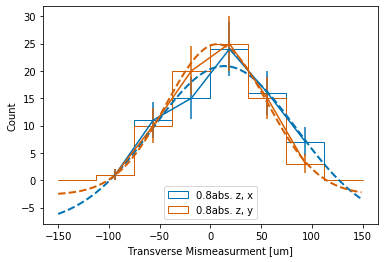

sigma x:  3829.803112285735 +/- 2959790.0062543736
sigma y:  59.26682476855291 +/- 22.570551754097117


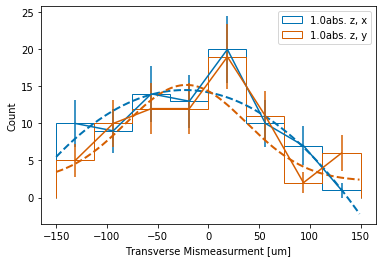

In [53]:
# Git mismeasurement versus abs. z using method 2

abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2 = Mismeasurment_vs_z( all_z = all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2) 


Text(0, 0.5, 'Effective Point Resolution [um]')

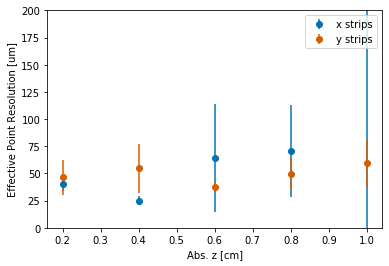

In [55]:
plt.errorbar(abs_z,x_sigmas2,x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
plt.errorbar(abs_z,y_sigmas2,y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
plt.legend()
plt.ylim((0,200))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")




